In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys
import glob

sys.path.append("../../../scripts")
%aimport initial_map
%aimport map_refiner
%aimport complexity
%aimport finder
%aimport preprocess
%aimport complexity
%aimport plotting
%aimport umi_deduplicate

from tqdm import tqdm  # progress bar

# Umi tools attempt
1. Use umi extract on fastq to save file with only BC as read, then UMI as the header
2. Make a .fa file using all unique BCs
3. Align fastq to the fa as sam -> bam
4. Run umi demultiplex

---
## 1. Umi extract

In [5]:
# Will run on test set first
test_df = pd.read_csv("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15.fastq.gz.assembled.fastq", header = None)
test_df

,0
0,@LH00707:68:22J52KLT4:1:2411:42486:18571 1:N:0...
1,AGGTTGTGGGCCAAATCATAAGAAATTCGCGGGCCCCGTAAGTAAT...
2,+
3,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
4,@LH00707:68:22J52KLT4:1:1465:17326:5568 1:N:0:...
...,...
39995,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII9IIIIIIIIIIII...
39996,@LH00707:68:22J52KLT4:1:2198:18701:9576 1:N:0:...
39997,GGCCCGTGGTGAAAATCATAAGAAATTCGCGGGCCCGAGTCTTTTT...
39998,+


In [7]:
# Last 12 are the UMI, reverse complemented to first 12
# CGCGCC preceder, reverse complemented to -> GGCGCG post
# GGGCCC pre, reverse complemented to -> GGGCCC pre

In [20]:
test_df[0].str.extractall(r'^(?P<umi_1>.{12})(?P<discard_1>.*GGGCCC)(?P<BC>.*?)(?P<discard_2>GGCGCG.*)')

,,umi_1,discard_1,BC,discard_2
,match,,,,
1,0,AGGTTGTGGGCC,AAATCATAAGAAATTCGCGGGCCC,CGTAAGTAATC,GGCGCGCCTCAGCTAGTCAAGCAACTGGATCAGAAGCATCAAATTT...
5,0,GTAGCGTTGTTT,AAATCATAAGAAATTCGCGGGCCC,TAACACGTGGT,GGCGCGCCTCAGCTAGTCAAACTGGAATATCATTATCAAACAAAGA...
9,0,GTTGTATGGAAC,AAATCATAAGAAATTCGCGGGCCC,TGCACATCGTA,GGCGCGCCTCAGCTAGTCATTCATGAATCCAACCAGAAGAAACAGC...
13,0,TTTGCATTAGGA,AAATCATAAGAAATTCGCGGGCCC,ACTTGCGCGGG,GGCGCGCCTCAGCTAGTCATTGAGATGGCCATGGTTGAGAATGAGC...
17,0,GAGTTCTTAAGT,AAATCATAAGAAATTCGCGGGCCC,GCGGATGGTCT,GGCGCGCCTCAGCTAGTCAATAAGCTCTTTCATCTTGATTCTGAGC...
...,...,...,...,...,...
39981,0,GGGTGTTGTTCA,AAATCATAAGAAATTCGCGGGCCC,TTAGATTTATA,GGCGCGCCTCAGCTAGTCAAATCAATTCTGGTTGTGGTTGAGTTTG...
39985,0,CATTGGGTGGTC,AAATCATAAGAAATTCGCGGGCCC,CGTTACATTTA,GGCGCGCCTCAGCTAGTCACAAATTAGAAGAAGAAGCAGAACCAAC...
39989,0,CTGGTTGGCTAT,AAATCATAAGAAATTCGCGGGCCC,GTTCTGTCACA,GGCGCGCCTCAGCTAGTCAATCATAAATAGTTGGAACAGCTGGAGA...


In [21]:
test_df[0].str.extractall(r'^(?P<umi_1>.{12})(?P<discard_1>.*GGGCCC).*?(?P<discard_2>GGCGCG.*)')

,,umi_1,discard_1,discard_2
,match,,,
1,0,AGGTTGTGGGCC,AAATCATAAGAAATTCGCGGGCCC,GGCGCGCCTCAGCTAGTCAAGCAACTGGATCAGAAGCATCAAATTT...
5,0,GTAGCGTTGTTT,AAATCATAAGAAATTCGCGGGCCC,GGCGCGCCTCAGCTAGTCAAACTGGAATATCATTATCAAACAAAGA...
9,0,GTTGTATGGAAC,AAATCATAAGAAATTCGCGGGCCC,GGCGCGCCTCAGCTAGTCATTCATGAATCCAACCAGAAGAAACAGC...
13,0,TTTGCATTAGGA,AAATCATAAGAAATTCGCGGGCCC,GGCGCGCCTCAGCTAGTCATTGAGATGGCCATGGTTGAGAATGAGC...
17,0,GAGTTCTTAAGT,AAATCATAAGAAATTCGCGGGCCC,GGCGCGCCTCAGCTAGTCAATAAGCTCTTTCATCTTGATTCTGAGC...
...,...,...,...,...
39981,0,GGGTGTTGTTCA,AAATCATAAGAAATTCGCGGGCCC,GGCGCGCCTCAGCTAGTCAAATCAATTCTGGTTGTGGTTGAGTTTG...
39985,0,CATTGGGTGGTC,AAATCATAAGAAATTCGCGGGCCC,GGCGCGCCTCAGCTAGTCACAAATTAGAAGAAGAAGCAGAACCAAC...
39989,0,CTGGTTGGCTAT,AAATCATAAGAAATTCGCGGGCCC,GGCGCGCCTCAGCTAGTCAATCATAAATAGTTGGAACAGCTGGAGA...


In [22]:
# Command:
# umi_tools extract --stdin=/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15.fastq.gz.assembled.fastq --bc-pattern='^(?P<umi_1>.{12})(?P<discard_1>.*GGGCCC).*?(?P<discard_2>GGCGCG.*)' --extract-method=regex --log=/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15_umi_extracted.log --stdout=/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15_umi_extracted.fastq
# This worked!

In [24]:
# Now make a fasta file wiht all possible barcode sequences

In [29]:
test_df["barcodes"] = test_df[0].str.extract(r'GGGCCC(.*?)GGCGCG')
test_df = test_df.dropna()
test_df

,0,barcodes
1,AGGTTGTGGGCCAAATCATAAGAAATTCGCGGGCCCCGTAAGTAAT...,CGTAAGTAATC
5,GTAGCGTTGTTTAAATCATAAGAAATTCGCGGGCCCTAACACGTGG...,TAACACGTGGT
9,GTTGTATGGAACAAATCATAAGAAATTCGCGGGCCCTGCACATCGT...,TGCACATCGTA
13,TTTGCATTAGGAAAATCATAAGAAATTCGCGGGCCCACTTGCGCGG...,ACTTGCGCGGG
17,GAGTTCTTAAGTAAATCATAAGAAATTCGCGGGCCCGCGGATGGTC...,GCGGATGGTCT
...,...,...
39981,GGGTGTTGTTCAAAATCATAAGAAATTCGCGGGCCCTTAGATTTAT...,TTAGATTTATA
39985,CATTGGGTGGTCAAATCATAAGAAATTCGCGGGCCCCGTTACATTT...,CGTTACATTTA
39989,CTGGTTGGCTATAAATCATAAGAAATTCGCGGGCCCGTTCTGTCAC...,GTTCTGTCACA
39993,TTTCCATATTGTAAATCATAAGAAATTCGCGGGCCCCGGGGATGAG...,CGGGGATGAGA


In [31]:
unique_barcodes = test_df["barcodes"].drop_duplicates()
unique_barcodes

1        CGTAAGTAATC
5        TAACACGTGGT
9        TGCACATCGTA
13       ACTTGCGCGGG
17       GCGGATGGTCT
            ...     
39945    TAACACCACAT
39965    GCGGGGCGGCG
39969    CGGATGCAGTG
39977    ATGACAGCCGT
39985    CGTTACATTTA
Name: barcodes, Length: 7152, dtype: object

In [32]:
import protfasta

In [33]:
protfasta.write_fasta(dict(zip(unique_barcodes, unique_barcodes)), "../../../data/test_AD_1_15_barcodes.fa")

In [35]:
# Index the fa
! ml bio/bowtie2/2.5.1-gcc-11.4.0
! bowtie2-build /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15_barcodes.fa /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15_barcodes_index

/bin/bash: bowtie-build: command not found


In [ ]:
# Align fastq to fa -> SAM
! bowtie2 -x /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15_barcodes_index -U /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15_umi_extracted.fastq -S /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15_umi_extracted.sam

In [ ]:
# SAM -> BAM
! ml bio/samtools/1.17-gcc-11.4.0

In [ ]:
! samtools view -b /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15_umi_extracted.sam > /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15_umi_extracted.bam

In [ ]:
# Sort BAM
! samtools sort /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15_umi_extracted.bam -o /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15_umi_extracted.sorted.bam

In [ ]:
# Index BAM
! samtools index /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15_umi_extracted.sorted.bam

In [ ]:
# UMI Deduplication
! umi_tools dedup -I /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15_umi_extracted.sorted.bam --output-stats=/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15_deduplicated_stats -S /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15_umi_deduplicated.bam

In [ ]:
! samtools index test_AD_1_15_umi_deduplicated.bam

In [ ]:
! umi_tools count  -I test_AD_1_15_umi_deduplicated.bam  -S umi_counts_pos.tsv --per-contig

# Comparing output

In [37]:
umi_tools_output = pd.read_csv("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15/test_AD_1_15_umi_counts.tsv", sep = "\t")
umi_tools_output = umi_tools_output.rename(columns = {"gene" : "AD_BC", "count" : "UMI_tools_count"})
umi_tools_output

,AD_BC,UMI_tools_count
0,GATGTCAACGG,1
1,TGATAAGAACA,3
2,CGCTTTCCATA,1
3,CCAGGGCTGTA,1
4,TCGATAGATCC,2
...,...,...
7112,GGTGATTCTTT,1
7113,AAACAAGCCGT,1
7114,TAATCTCAGCG,1
7115,AACTCCAGAAA,1


In [38]:
simple_umi_results = pd.read_csv("../../../data/simple_umi_results.csv", index_col = 0)
simple_umi_results

,AD_BC,unique_AD_BC_umis
0,CGCGGCTACAA,13
1,TTATTCGAATT,13
2,AGTAACAGCTG,10
3,CAGAATGAGCG,10
4,GTCCACCGGAG,9
...,...,...
7112,TGACACCTTTC,1
7113,GATAAGCTATA,1
7114,TTCCTTATGTA,1
7115,CGTATATCTAT,1


In [39]:
umi_output_comparison = pd.merge(umi_tools_output, simple_umi_results)
umi_output_comparison.sort_values(by = "UMI_tools_count")

,AD_BC,UMI_tools_count,unique_AD_BC_umis
0,GATGTCAACGG,1,1
4404,TGTAATATATT,1,1
4403,CCGTCGACCCC,1,1
4402,GTTTCAACACG,1,1
4401,CGGTCTTTATA,1,1
...,...,...,...
5303,TGTGACCCCGC,9,9
36,CAGAATGAGCG,10,10
4866,AGTAACAGCTG,10,10
856,TTATTCGAATT,13,13


In [40]:
umi_output_comparison[umi_output_comparison["UMI_tools_count"] != umi_output_comparison['unique_AD_BC_umis']]

,AD_BC,UMI_tools_count,unique_AD_BC_umis


In [41]:
# Maybe aligned to reverse complement?

In [42]:
UMIs_extracted = pd.read_csv("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15/test_AD_1_15_umi_extracted.fastq", header = None)
# Number of total lines
n = len(UMIs_extracted)

# Column 1: rows 0,4,8,...
col1 = UMIs_extracted.iloc[0:n:4, 0].reset_index(drop=True)

# Column 2: rows 1,5,9,...
col2 = UMIs_extracted.iloc[1:n:4, 0].reset_index(drop=True)

# Combine into a new dataframe
df_new = pd.DataFrame({
    'UMI': col1,
    'AD_BC': col2
})

df_new["UMI"] = df_new["UMI"].str[1:]
df_new

,UMI,AD_BC
0,GGCCCACAACCT,GATTACTTACG
1,AAACAACGCTAC,ACCACGTGTTA
2,GTTCCATACAAC,TACGATGTGCA
3,TCCTAATGCAAA,CCCGCGCAAGT
4,ACTTAAGAACTC,AGACCATCCGC
...,...,...
9556,TGAACAACACCC,TATAAATCTAA
9557,GACCACCCAATG,TAAATGTAACG
9558,ATAGCCAACCAG,TGTGACAGAAC
9559,ACAATATGGAAA,TCTCATCCCCG


In [56]:
EC_AD_BC = finder.Barcode(name = "AD_BC",
                       preceder = "CGCGCC",
                       post = "GGGCCC",
                       length =11)
umi_mapper = initial_map.InitialMapper(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4.db",
                                       step_name = "umi_AD_1_15",
                                       seq_file = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15.fastq.gz.assembled.fastq",
                                       design_file_path = None,
                                       bc_objects = [ EC_AD_BC],
                                       reverse_complement = True,
                                       umi_length = 12)
umi_map = umi_mapper.create_map()
umi_map

Reading 1 FASTQ/TXT file(s)...
Reverse complement of sequences...
Extracting 1 barcodes...
Extracting UMIs (12 bases from end)...
Mapping complete.
Done in 0.31 seconds.



,sequence,AD_BC,AD_BC_qual,UMI
0,TGCGGGCTCTACTTCATCGGCTAGCTCTCCACCATTGTCTCAGCTA...,GATTACTTACG,True,GGCCCACAACCT
1,TGCGGGCTCTACTTCATCGGCTAGCGCTGCTGTTGTTGAATCATTC...,ACCACGTGTTA,True,AAACAACGCTAC
2,TGCGGGCTCTACTTCATCGGCTAGCTCTTGGATTGGTGGTAAATCA...,TACGATGTGCA,True,GTTCCATACAAC
3,TGCGGGCTCTACTTCATCGGCTAGCTATTTGAAATCTCCAGACTTT...,CCCGCGCAAGT,True,TCCTAATGCAAA
4,TGCGGGCTCTACTTCATCGGCTAGCGTTGCTTCTATGGTCAACCAG...,AGACCATCCGC,True,ACTTAAGAACTC
...,...,...,...,...
9995,TGCGGGCTCTACTTCATCGGCTAGCCATTCTGATTTGGATAATCCA...,TATAAATCTAA,True,TGAACAACACCC
9996,TGCGGGCTCTACTTCATCGGCTAGCGATGCTATGAACTCTTTGGAA...,TAAATGTAACG,True,GACCACCCAATG
9997,TGCGGGCTCTACTTCATCGGCTAGCATGGCTATGCAAGATATGGAT...,TGTGACAGAAC,True,ATAGCCAACCAG
9998,TGCGGGCTCTACTTCATCGGCTAGCCCAGTTATTAGAGATACTTTG...,TCTCATCCCCG,True,ACAATATGGAAA


In [1]:
umi_map[umi_map["AD_BC"] == "AGTGTGTAAAA"]

NameError: name 'umi_map' is not defined

<Axes: xlabel='UMI_tools_count', ylabel='unique_AD_BC_umis'>

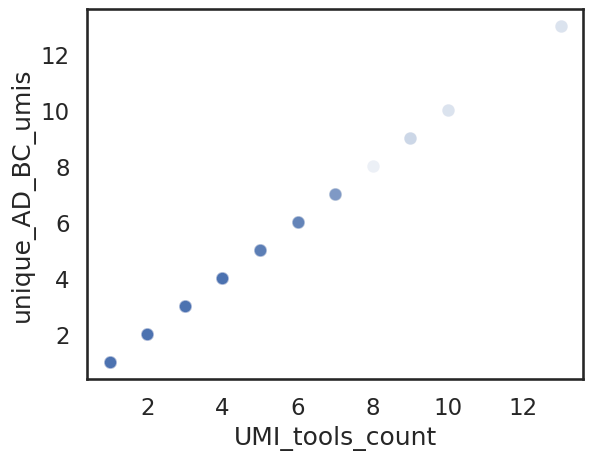

In [44]:
sns.scatterplot(data = umi_output_comparison, x = "UMI_tools_count", y = "unique_AD_BC_umis", alpha = 0.1)

# Adding to UMI scripts

## First trying on test file.

In [57]:
EC_AD_BC = finder.Barcode(name = "AD_BC",
                       preceder = "CGCGCC",
                       post = "GGGCCC",
                       length =11)

In [141]:
umi_mapper = initial_map.InitialMapper(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4.db",
                                       step_name = "test_1_15_umi",
                                       seq_file = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15.fastq.gz.assembled.fastq",
                                       design_file_path = None,
                                       bc_objects = [ EC_AD_BC],
                                       reverse_complement = True,
                                       umi_length = 12)
umi_map = umi_mapper.create_map()
umi_map

Reading 1 FASTQ/TXT file(s)...
Reverse complement of sequences...
Extracting 1 barcodes...
Extracting UMIs (12 bases from end)...
Mapping complete.
Done in 0.24 seconds.



,sequence,AD_BC,AD_BC_qual,UMI,Designed
0,TGCGGGCTCTACTTCATCGGCTAGCTCTCCACCATTGTCTCAGCTA...,GATTACTTACG,True,GGCCCACAACCT,1
1,TGCGGGCTCTACTTCATCGGCTAGCGCTGCTGTTGTTGAATCATTC...,ACCACGTGTTA,True,AAACAACGCTAC,1
2,TGCGGGCTCTACTTCATCGGCTAGCTCTTGGATTGGTGGTAAATCA...,TACGATGTGCA,True,GTTCCATACAAC,1
3,TGCGGGCTCTACTTCATCGGCTAGCTATTTGAAATCTCCAGACTTT...,CCCGCGCAAGT,True,TCCTAATGCAAA,1
4,TGCGGGCTCTACTTCATCGGCTAGCGTTGCTTCTATGGTCAACCAG...,AGACCATCCGC,True,ACTTAAGAACTC,1
...,...,...,...,...,...
9995,TGCGGGCTCTACTTCATCGGCTAGCCATTCTGATTTGGATAATCCA...,TATAAATCTAA,True,TGAACAACACCC,1
9996,TGCGGGCTCTACTTCATCGGCTAGCGATGCTATGAACTCTTTGGAA...,TAAATGTAACG,True,GACCACCCAATG,1
9997,TGCGGGCTCTACTTCATCGGCTAGCATGGCTATGCAAGATATGGAT...,TGTGACAGAAC,True,ATAGCCAACCAG,1
9998,TGCGGGCTCTACTTCATCGGCTAGCCCAGTTATTAGAGATACTTTG...,TCTCATCCCCG,True,ACAATATGGAAA,1


In [142]:
refiner = map_refiner.MapRefiner(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4.db",
                                    bc_objects=[EC_AD_BC],
                                    column_pairs = [],
                                    reads_threshold = 1,
                                    map_order = ['quality_designed'],
                                    step_name="test_1_15_umi", #Should be TIme point, replicate (don't need to specify BC type(s))
                                    descriptor = "")
refiner.refine_map_from_db()

Base prefix (stable across descriptors): test_1_15_umi_AD_BC_
Full prefix for this instance: test_1_15_umi_AD_BC_

Using the following step order:
1. initial
2. quality_designed

Filtering to quality and designed...
Done in 0.02 seconds.

Done.


In [134]:
! rm -r /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15

In [143]:
deduplicator = umi_deduplicate.UMIDeduplicator(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4.db",
                                                    bc_objects = [EC_AD_BC],
                                                    step_name = "test_1_15_umi",
                                                    descriptor = "",
                                                    step1_map_name = "step1_AD_AD_BC_RPTR_BC_quality_designed",
                                                    fastq_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15.fastq.gz.assembled.fastq",
                                                    umi_length = 12,
                                                    output_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15")

In [144]:
deduplicator.run_both_deduplications()

Starting simple deduplication.
Saved to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15/test_AD_1_15_AD_BC_umis_unique_with_step1_map.csv
Finished simple deduplication.

Starting UMI Tools directional deduplication.
Generating FASTQ with UMIs in header and barcodes as sequence...
Writing FASTQ to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15/test_AD_1_15_umi_extracted.fastq (9547 reads)...


Writing FASTQ: 100%|██████████| 9547/9547 [00:00<00:00, 1599098.29it/s]

FASTQ complete: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15/test_AD_1_15_umi_extracted.fastq
Done in 0.02 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: test_1_15_umi_AD_BC_unique_barcodes
Writing FASTA to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15/test_AD_1_15_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15/test_AD_1_15_barcodes_index



Building a SMALL index
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15/test_AD_1_15_barcodes_index.3.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15/test_AD_1_15_barcodes_index.3.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15/test_AD_1_15_barcodes_index.4.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15/test_AD_1_15_barcodes_index.4.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15/test_AD_1_15_barcodes_index.1.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15/test_AD_1_15_barcodes_index.1.bt2
Renaming /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15/test_AD_1_15_barcodes_index.2.bt2.tmp to /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15/test_AD_1_15_barcodes_index.2.bt2


Done in 0.75 seconds.

Aligning .FASTQ to reference .FA ...


9547 reads; of these:
  9547 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    9547 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate
[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Converting SAM -> BAM ...
Sorting BAM ...
Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15/test_AD_1_15_umi_extracted.sorted.bam -S /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/test_AD_1_15/test_AD_1_15_umi_deduplicated.bam
# job started at Tue Oct 21 18:06:48 2025 on n0179.savio2 -- 6451eea4-dd77-48f7-b496-503ddc40b519
# pid: 3715063, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filter_umi                            

,AD,AD_BC,RPTR_BC,AD_BC_umis_unique,info,AD_BC_umis_directional_deduplic
0,AAACAAATGTATATTGGTTCTAATAAACCATTGGGTAAAGATCATA...,TCCCACCTCCC,CGCCAGTTCACGCA,1,test_1_15_umi,1
1,AAACAACCAGATGTTGCTACTTGGGATGCTCATTCTAATAAAGGTC...,GTAAGGAAGCC,TCTCAAATTATGAA,1,test_1_15_umi,1
2,AAACAAGGTAATAAGATGTTCTCTGAATTGGATTTGTTGGACTTTG...,ACGAGCACCTA,CTCGGGGCCCTCAA,1,test_1_15_umi,1
3,AAACAATTGCAAACTAATTCTAATATGTCTGATGATACATTTGCTG...,TATCCCCCCGG,AGCCGTGGGACGCT,1,test_1_15_umi,1
4,AAACAATTGCAATGGAAACAATTTCAGAATTATCAAAGAAGAAGAT...,GTAAACTCAAG,TCGGCTACCGCTCA,2,test_1_15_umi,2
...,...,...,...,...,...,...
4939,TTTGTTAAACAAGAATCTCCAGCTTTGGCTGAATTGGCTTTGTGTA...,TCATCTAGATA,AACACAAAATGAAG,1,test_1_15_umi,1
4940,TTTGTTACTGATCATCATAAGAGATGGTTGACTCAACCACAATCTC...,CACAAGTGCTT,AGTCGTAATATATG,1,test_1_15_umi,1
4941,TTTGTTATTTCTCAGAAGAAGAAACCAATCTTGGATGCTGCTTCTT...,CCCCGCCGAAA,TAGGCGTATAAATA,1,test_1_15_umi,1
4942,TTTGTTCATTTGTTGGCTGCATTTGATACTAGATTGGATTTGAAAT...,TCGTGGAAATA,CAGAACTCCCCTCT,1,test_1_15_umi,1


## Trying on a full file

In [34]:
EC_AD_BC = finder.Barcode(name = "AD_BC",
                       preceder = "CGCGCC",
                       post = "GGGCCC",
                       length =11)

full_deduplicator = umi_deduplicate.UMIToolsDeduplicator(db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4.db",
                                                    bc_objects = [EC_AD_BC],
                                                    step_name = "umi_1_15",
                                                    descriptor = "",
                                                    step1_map_name = "",
                                                    fastq_path = "/global/scratch/projects/fc_mvslab/data/sequencing/20250218_MZCCSCU_MedGenome/MZ/results/assembled/AD_1_15.fastq.gz.assembled.fastq",
                                                    umi_length = 12,
                                                    reverse_complement = True,
                                                    output_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/AD_1_15")
full_deduplicator.run_full_umi_pipeline()

Generating FASTQ with UMIs in header and barcodes as sequence...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

InvalidInputException: Invalid Input Error: Attempting to execute an unsuccessful or closed pending query result
Error: Invalid Error: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/traitlets/traitlets.py(720): __set__
  /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/notebooks/script_development/UMI/../../../scripts/umi_deduplicate.py(227): generate_fastq
  /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/notebooks/script_development/UMI/../../../scripts/preprocess.py(19): wrapper
  /global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/notebooks/script_development/UMI/../../../scripts/umi_deduplicate.py(359): run_full_umi_pipeline
  /tmp/ipykernel_3704460/345045656.py(15): <module>
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3553): run_code
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3493): run_ast_nodes
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3311): run_cell_async
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3106): _run_cell
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3051): run_cell
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/ipykernel/zmqshell.py(549): run_cell
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/ipykernel/ipkernel.py(429): do_execute
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/ipykernel/kernelbase.py(767): execute_request
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/ipykernel/kernelbase.py(429): dispatch_shell
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/ipykernel/kernelbase.py(523): process_one
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/ipykernel/kernelbase.py(534): dispatch_queue
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/asyncio/events.py(80): _run
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/asyncio/base_events.py(1922): _run_once
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/asyncio/base_events.py(607): run_forever
  /global/home/users/sanjanakotha/.local/lib/python3.11/site-packages/tornado/platform/asyncio.py(205): start
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/ipykernel/kernelapp.py(701): start
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/traitlets/config/application.py(992): launch_instance
  /global/software/rocky-8.x86_64/manual/modules/langs/anaconda3/2024.02-1/lib/python3.11/site-packages/ipykernel_launcher.py(17): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main


In [3]:
# I ran a job instead
# COmpariong output to Emily

In [6]:
AD_1_15_results = pd.read_csv("../../../data/AD_1_15/AD_1_15_umi_counts.tsv", sep = "\t")
AD_1_15_results = AD_1_15_results.rename(columns = {"gene" : "Barcode_AD", "count" : "Umi_tools_count"})
AD_1_15_results

,Barcode_AD,Umi_tools_count
0,TCCCCATCCCG,493
1,TATGACCCAAC,72
2,ACATCATGCTC,354
3,TCACGTTTAAG,925
4,TTTAAAAAACA,513
...,...,...
379238,GTATTATCTAA,1
379239,GAATCCTGGGG,1
379240,AGATGTGGTGT,1
379241,TTGACAAAACC,1


In [7]:
# All activities from EC's demultixed UMI calcuations
concatenated_df = pd.read_csv("../../../from_EC/20250226_TREBL_MAZ06/demultiplexed_counts.csv")
concatenated_df["Time"] = concatenated_df["Library"].str.split("_").str[1]
concatenated_df["sample"] = concatenated_df["Library"].str.split("_").str[0]
concatenated_df = concatenated_df.rename(columns={"Ratio_negctrlnorm": "Ratio_negCTRLnorm",
    "UMIs_RPTR": "RPTR_UMIs",
    "UMIs_AD": "AD_UMIs"})
concatenated_df = concatenated_df[concatenated_df["Library"] == "1_15"]
concatenated_df =concatenated_df[["Barcode_AD", "AD_UMIs"]]
concatenated_df

,Barcode_AD,AD_UMIs
97241,CTATAGCCCTC,1073
97242,GGAGTTCCCCA,281
97243,GCCAAGGTAGT,1015
97244,CGTACGTTAGC,489
97245,TATTCGTGCCT,515
...,...,...
113612,CGTTTACAGAT,50
113613,GGATGACTTTC,11
113614,GACGTTGTACG,370
113615,ATAGAGCTTCG,77


In [8]:
# Combine separated Bcs
concatenated_df = concatenated_df.groupby("Barcode_AD").sum().reset_index()
concatenated_df

,Barcode_AD,AD_UMIs
0,AAAAAAAAGGA,168
1,AAAAAAAATAA,900
2,AAAAAAAGGAT,19
3,AAAAAACCTCC,427
4,AAAAAACTGAA,257
...,...,...
16302,TTTTTTAATGA,44
16303,TTTTTTAGTTA,120
16304,TTTTTTATATC,52
16305,TTTTTTCCTTC,1341


In [9]:
EC_SK_comparison = pd.merge(AD_1_15_results, concatenated_df)
EC_SK_comparison

,Barcode_AD,Umi_tools_count,AD_UMIs
0,TCCCCATCCCG,493,526
1,TATGACCCAAC,72,79
2,TCACGTTTAAG,925,1001
3,CAGGGGCTTTA,885,930
4,CGCCAAGAATG,545,589
...,...,...,...
16226,ACATCAGTATG,11,11
16227,CCTGCCGTCGG,35,37
16228,GTTACCGCGTA,16,17
16229,TGTATTTGCAA,4,4


<Axes: xlabel='count_diff', ylabel='Count'>

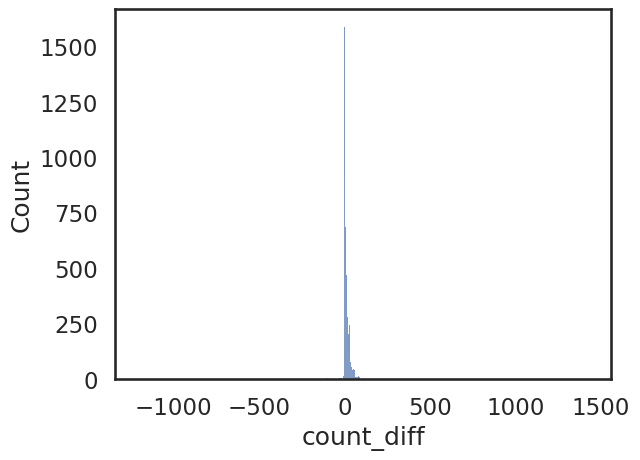

In [10]:
EC_SK_comparison["count_diff"] = EC_SK_comparison["AD_UMIs"] - EC_SK_comparison["Umi_tools_count"]
sns.histplot(EC_SK_comparison["count_diff"])

In [11]:
# When does UMI tools have over
EC_SK_comparison[EC_SK_comparison["count_diff"] < 0].sort_values(by = 'count_diff')

,Barcode_AD,Umi_tools_count,AD_UMIs,count_diff
9484,TCTACCCCCAT,1933,726,-1207
246,TTCTTTCCTCC,1132,2,-1130
6736,TTAACCGCCAA,1123,1,-1122
13534,CAACTCATGGT,966,110,-856
10523,ATGAGGGGATT,836,3,-833
...,...,...,...,...
16153,ACTGGGTCTGC,155,154,-1
232,CCCGTCCCCGC,7,6,-1
216,CGTTTCCGTGG,63,62,-1
16216,CCCCCCTACCG,23,22,-1


In [12]:
AD_1_15_barcodes = pd.read_csv("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/AD_1_15/AD_1_15_barcodes.fa", header = None)
AD_1_15_barcodes

,0
0,>TCCCCATCCCG
1,TCCCCATCCCG
2,>TATGACCCAAC
3,TATGACCCAAC
4,>ACATCATGCTC
...,...
806525,ANGNCANGCGA
806526,>TTGACAAAACC
806527,TTGACAAAACC
806528,>AAAAGATGAGA


In [13]:
"TTCTTTCCTCC" in list(AD_1_15_barcodes[0])

True

In [14]:
SK_simple_results = pd.read_csv("../../../output/GCN4/step1_map_with_umi_1_15.csv")
SK_simple_results

,AD,AD_BC,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed,unique_AD_BC_umis,info
0,CCATCTGACTTTCCATTTCCAGAAACTTTGACTTCTTCTACTGCTT...,TTATTCGAATT,TCGAACACGGCTTC,138,True,True,True,1,11616,umi_1_15
1,TCTTCTTCATTTGGTTTGTCTGGTAATTCTTCTCAACATAGATTGT...,CGCGGCTACAA,GGAGGGGTCAGAAG,194,True,True,True,1,7224,umi_1_15
2,TTTCCACCATCTTCTCCATCTATGACTACTGAAATGGTTTCTTTGC...,AGTAACAGCTG,CTTGACTAAAATCA,64,True,True,True,1,7211,umi_1_15
3,AATACATTTCATTCTGCTTATTCTTCTCCAGCTGTTCCAACTTTGT...,ATACCGCCAAC,ATCAGCCTTCCAAA,63,True,True,True,1,5633,umi_1_15
4,AGACCAGCTAGACCACCAGTTCCATTGTTCTCTCAATCTACTGGTT...,TCCTAAGCTCG,CCCCAGACTCGTTG,261,True,True,True,1,5467,umi_1_15
...,...,...,...,...,...,...,...,...,...,...
37970,ACTCAATCTACTTGGCCACCATCTTCTTCTTCTTCTCAACCAGCTC...,TGACACCCCAA,CCCTGCCCTCCTGG,41,True,True,True,1,1,umi_1_15
37971,GACCCAAGACCATTTACTATGTCTCCAGATATGTTGGATATGCAAA...,AAAACAAATAG,CATATGTCCACGTT,38,True,True,True,1,1,umi_1_15
37972,CACTTTGATGTTTCTCCATTTGTTGGTGATGGTGATTTGGATCAAT...,AGCCCTGCCGC,CCCCCCACAACGTT,57,True,True,True,1,1,umi_1_15
37973,TCTACTTCTTCTGATCCAAATACTTGGACTTCTTTGTTTGATGATG...,GCTTCCCCTTA,TCAACAGAATACTC,66,True,True,True,1,1,umi_1_15


In [15]:
SK_simple_results = SK_simple_results.rename(columns = {"AD_BC" : "Barcode_AD", "unique_AD_BC_umis" : "SK_unique_UMIs"})
SK_simple_results

,AD,Barcode_AD,RPTR_BC,count,AD_qual,AD_BC_qual,RPTR_BC_qual,Designed,SK_unique_UMIs,info
0,CCATCTGACTTTCCATTTCCAGAAACTTTGACTTCTTCTACTGCTT...,TTATTCGAATT,TCGAACACGGCTTC,138,True,True,True,1,11616,umi_1_15
1,TCTTCTTCATTTGGTTTGTCTGGTAATTCTTCTCAACATAGATTGT...,CGCGGCTACAA,GGAGGGGTCAGAAG,194,True,True,True,1,7224,umi_1_15
2,TTTCCACCATCTTCTCCATCTATGACTACTGAAATGGTTTCTTTGC...,AGTAACAGCTG,CTTGACTAAAATCA,64,True,True,True,1,7211,umi_1_15
3,AATACATTTCATTCTGCTTATTCTTCTCCAGCTGTTCCAACTTTGT...,ATACCGCCAAC,ATCAGCCTTCCAAA,63,True,True,True,1,5633,umi_1_15
4,AGACCAGCTAGACCACCAGTTCCATTGTTCTCTCAATCTACTGGTT...,TCCTAAGCTCG,CCCCAGACTCGTTG,261,True,True,True,1,5467,umi_1_15
...,...,...,...,...,...,...,...,...,...,...
37970,ACTCAATCTACTTGGCCACCATCTTCTTCTTCTTCTCAACCAGCTC...,TGACACCCCAA,CCCTGCCCTCCTGG,41,True,True,True,1,1,umi_1_15
37971,GACCCAAGACCATTTACTATGTCTCCAGATATGTTGGATATGCAAA...,AAAACAAATAG,CATATGTCCACGTT,38,True,True,True,1,1,umi_1_15
37972,CACTTTGATGTTTCTCCATTTGTTGGTGATGGTGATTTGGATCAAT...,AGCCCTGCCGC,CCCCCCACAACGTT,57,True,True,True,1,1,umi_1_15
37973,TCTACTTCTTCTGATCCAAATACTTGGACTTCTTTGTTTGATGATG...,GCTTCCCCTTA,TCAACAGAATACTC,66,True,True,True,1,1,umi_1_15


In [16]:
EC_SK_comparison = pd.merge(EC_SK_comparison, SK_simple_results[["Barcode_AD", "SK_unique_UMIs"]]).drop_duplicates()
EC_SK_comparison

,Barcode_AD,Umi_tools_count,AD_UMIs,count_diff,SK_unique_UMIs
0,TCCCCATCCCG,493,526,33,536
2,TCACGTTTAAG,925,1001,76,1006
3,CAGGGGCTTTA,885,930,45,953
4,CGCCAAGAATG,545,589,44,605
6,AACTCTAGCGA,293,299,6,311
...,...,...,...,...,...
16731,CCCGATCTGTA,32,36,4,37
16732,ACATCAGTATG,11,11,0,11
16733,CCTGCCGTCGG,35,37,2,36
16734,GTTACCGCGTA,16,17,1,17


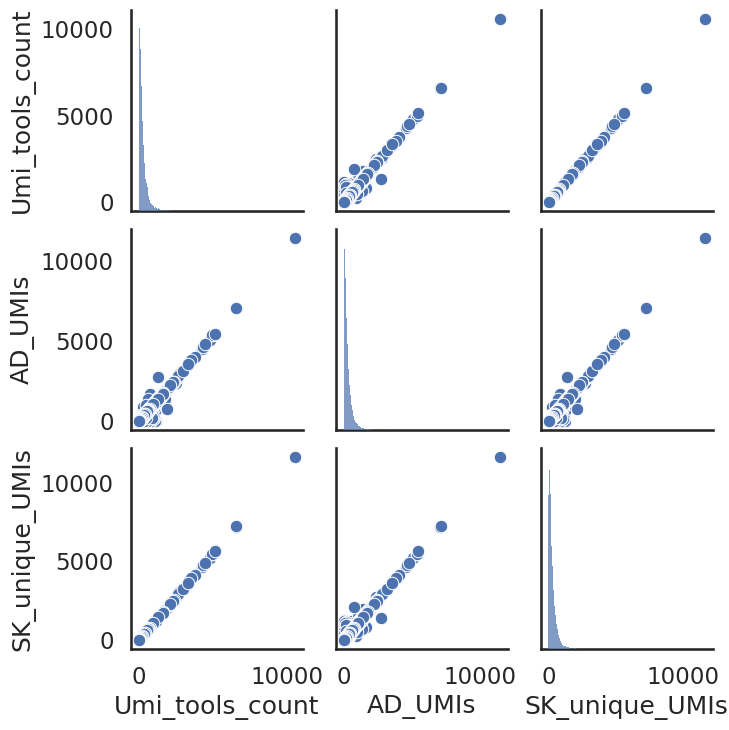

In [56]:
sns.pairplot(EC_SK_comparison[["Umi_tools_count", "AD_UMIs", "SK_unique_UMIs"]])

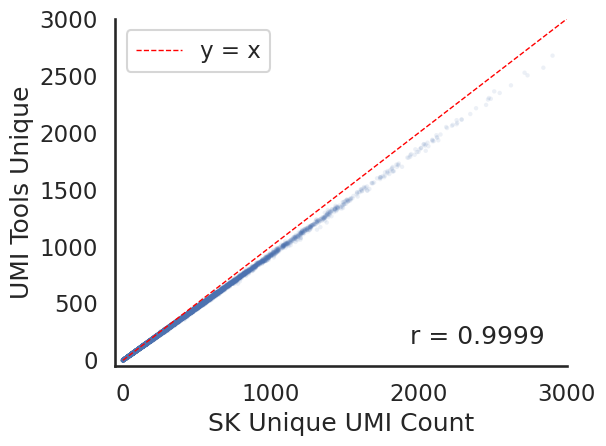

In [52]:
from scipy.stats import pearsonr

sns.set_context('talk')
# Scatter plot
sns.scatterplot(
    data=EC_SK_comparison, 
    y="UMI_tools_unique_UMIs", 
    x="SK_unique_UMIs", 
    alpha=0.1, 
    edgecolor='none', 
    s=10
)

# Set limits
lims = [
    np.min([EC_SK_comparison["SK_unique_UMIs"].min(), EC_SK_comparison["UMI_tools_unique_UMIs"].min()]),
    np.max([EC_SK_comparison["SK_unique_UMIs"].max(), EC_SK_comparison["UMI_tools_unique_UMIs"].max()])
]

# Add y = x and y = 2x reference lines
plt.plot(lims, lims, '--', color='red', linewidth=1, label='y = x')

# Add correlation coefficient
r, p = pearsonr(EC_SK_comparison["SK_unique_UMIs"], EC_SK_comparison["UMI_tools_unique_UMIs"])
plt.text(0.95, 0.05, f"r = {r:.4f}", transform=plt.gca().transAxes, 
         fontsize='medium', verticalalignment='bottom', ha = 'right')

plt.xlim(-50, 3000)
plt.ylim(-50, 3000)

# Aesthetics
sns.despine()
plt.xlabel("SK Unique UMI Count")
plt.ylabel("UMI Tools Unique")
plt.legend()
plt.tight_layout()
plt.show()

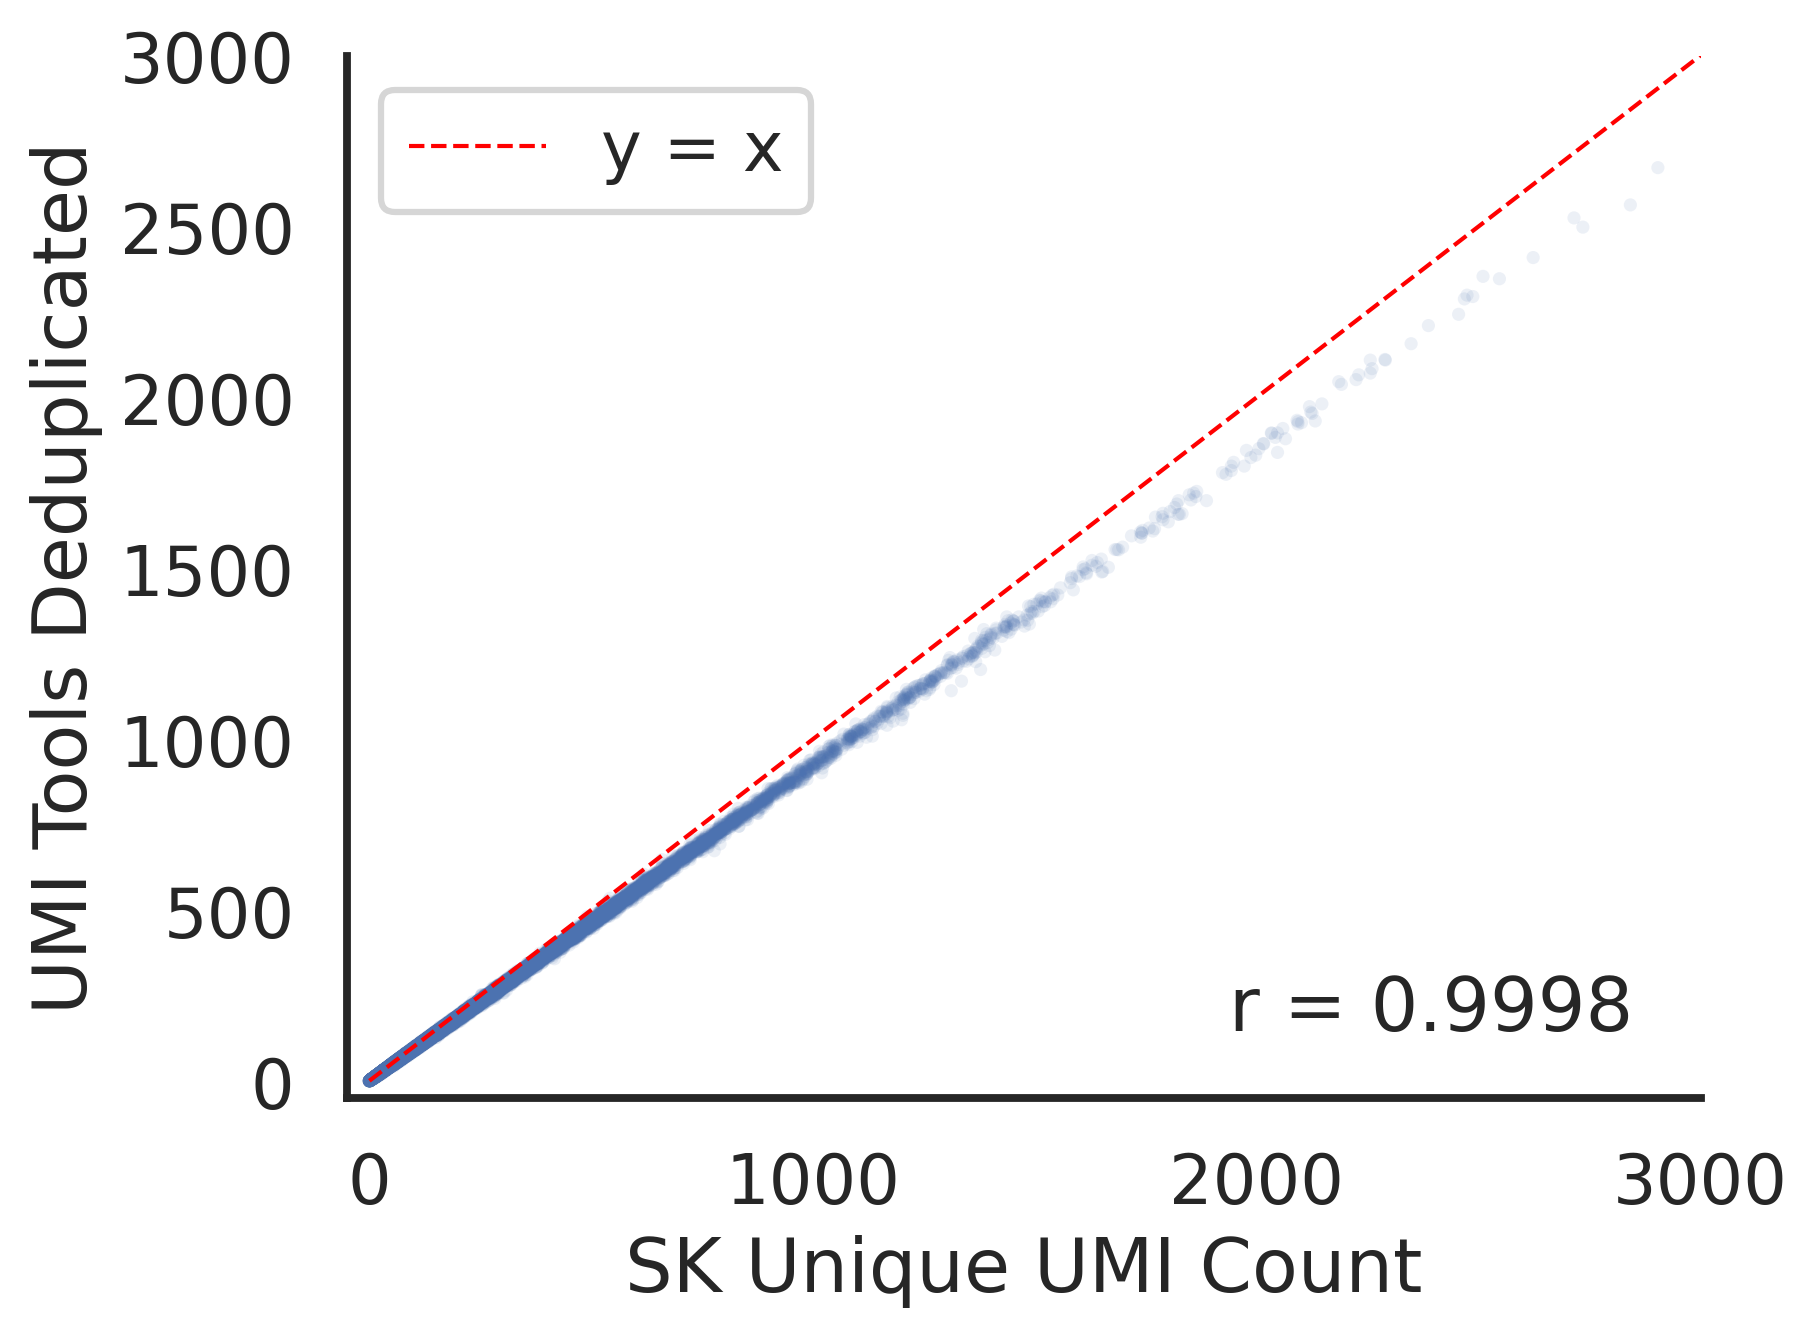

In [17]:
from scipy.stats import pearsonr

plt.figure(dpi = 300)
sns.set_context('talk')
# Scatter plot
sns.scatterplot(
    data=EC_SK_comparison, 
    y="Umi_tools_count", 
    x="SK_unique_UMIs", 
    alpha=0.1, 
    edgecolor='none', 
    s=10
)

# Set limits
lims = [
    np.min([EC_SK_comparison["Umi_tools_count"].min(), EC_SK_comparison["SK_unique_UMIs"].min()]),
    np.max([EC_SK_comparison["Umi_tools_count"].max(), EC_SK_comparison["SK_unique_UMIs"].max()])
]

# Add y = x and y = 2x reference lines
plt.plot(lims, lims, '--', color='red', linewidth=1, label='y = x')

# Add correlation coefficient
r, p = pearsonr(EC_SK_comparison["Umi_tools_count"], EC_SK_comparison["SK_unique_UMIs"])
plt.text(0.95, 0.05, f"r = {r:.4f}", transform=plt.gca().transAxes, 
         fontsize='medium', verticalalignment='bottom', ha = 'right')

plt.xlim(-50, 3000)
plt.ylim(-50, 3000)

# Aesthetics
sns.despine()
plt.xlabel("SK Unique UMI Count")
plt.ylabel("UMI Tools Deduplicated")
plt.legend()
plt.tight_layout()
plt.show()

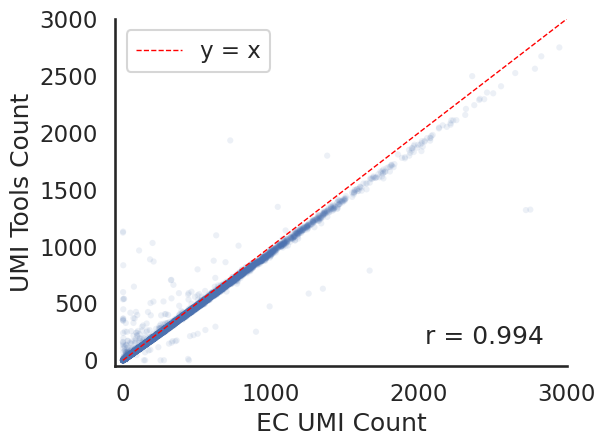

In [13]:
from scipy.stats import pearsonr

sns.set_context('talk')
# Scatter plot
sns.scatterplot(
    data=EC_SK_comparison, 
    y="Umi_tools_count", 
    x="AD_UMIs", 
    alpha=0.1, 
    edgecolor='none', 
    s=20
)

# Set limits
lims = [
    np.min([EC_SK_comparison["Umi_tools_count"].min(), EC_SK_comparison["AD_UMIs"].min()]),
    np.max([EC_SK_comparison["Umi_tools_count"].max(), EC_SK_comparison["AD_UMIs"].max()])
]

# Add y = x and y = 2x reference lines
plt.plot(lims, lims, '--', color='red', linewidth=1, label='y = x')

# Add correlation coefficient
r, p = pearsonr(EC_SK_comparison["Umi_tools_count"], EC_SK_comparison["AD_UMIs"])
plt.text(0.95, 0.05, f"r = {r:.3f}", transform=plt.gca().transAxes, 
         fontsize='medium', verticalalignment='bottom', ha = 'right')

plt.xlim(-50, 3000)
plt.ylim(-50, 3000)

# Aesthetics
sns.despine()
plt.xlabel("EC UMI Count")
plt.ylabel("UMI Tools Count")
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
# Redone with new alignment parameters

In [15]:
AD_1_15_deduplicated_stats_per_umi = pd.read_csv("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/AD_1_15/AD_1_15_deduplicated_stats_per_umi.tsv",sep = "\t")
AD_1_15_deduplicated_stats_per_umi

,UMI,median_counts_pre,times_observed_pre,total_counts_pre,median_counts_post,times_observed_post,total_counts_post
0,AAAAAAAAAAAA,6,70,608,14,42,571
1,AAAAAAAAAAAC,5,25,198,14,15,187
2,AAAAAAAAAAAG,2,12,109,16,6,105
3,AAAAAAAAAAAT,2,9,95,9,8,101
4,AAAAAAAAAACA,10,11,117,11,10,118
...,...,...,...,...,...,...,...
5654210,TTTTTTTTTTAA,2,1,2,2,1,2
5654211,TTTTTTTTTTCT,7,1,7,7,1,7
5654212,TTTTTTTTTTGC,5,1,5,5,1,5
5654213,TTTTTTTTTTTG,1,1,1,1,1,1


In [16]:
AD_1_15_deduplicated_stats_per_umi[AD_1_15_deduplicated_stats_per_umi["total_counts_pre"] < AD_1_15_deduplicated_stats_per_umi["total_counts_post"]]

,UMI,median_counts_pre,times_observed_pre,total_counts_pre,median_counts_post,times_observed_post,total_counts_post
3,AAAAAAAAAAAT,2,9,95,9,8,101
4,AAAAAAAAAACA,10,11,117,11,10,118
5,AAAAAAAAAACC,1,9,58,1,6,60
6,AAAAAAAAAACG,7,13,173,11,12,181
7,AAAAAAAAAACT,15,15,229,17,14,242
...,...,...,...,...,...,...,...
5654155,TTTTTTTTAACA,11,2,22,11,2,23
5654165,TTTTTTTTAGCT,5,1,5,6,1,6
5654183,TTTTTTTTCTGG,27,1,27,28,1,28
5654186,TTTTTTTTGAAC,17,1,17,18,1,18


In [17]:
AD_1_15_deduplicated_stats_per_umi_per_position = pd.read_csv("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/data/AD_1_15/AD_1_15_deduplicated_stats_per_umi_per_position.tsv",sep = "\t")
AD_1_15_deduplicated_stats_per_umi_per_position

,counts,instances_pre,instances_post
0,1,2064379,1545474
1,2,547711,491769
2,3,331828,319840
3,4,248532,243991
4,5,211867,209583
...,...,...,...
92,93,2,2
93,95,1,0
94,96,0,1
95,100,1,2
